#### 7

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 4)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,1,1)
var_sarpdq   <-  c(2,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

var_char  <-  c(2,1)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)


var_countries  <-  dim(read.csv(file="../clustering/hts_eu_a10_state.csv", header=TRUE, sep=",", row.names =1 ))[2]+1
all_models_list  <- list()
this_file_models_list  <-  list()
this_model_list  <-  list()



In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
         
 
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(rep(0, var_countries), rep(1, (ncol(allts)-var_countries) )))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)     
    }
this_file_models_list[[1]]  <-  this_model_list



[1]  1 48 49 56


Warning message in auto.arima(msts(allts[, j], seasonal.periods = var_freq), stationary = FALSE, :
“Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.”

          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Warning message in auto.arima(msts(allts[, j], seasonal.periods = var_freq), stationary = FALSE, :
“Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.”

[1]  9 56 57 64
|[1] 13 60 61 68
|[1] 17 64 65 72
[1] 21 68 69 76


Warning message in auto.arima(msts(allts[, j], seasonal.periods = var_freq), stationary = FALSE, :
“Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.”

In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
df_acc

ME,RMSE,MAPE,Iteration
21.40286,27.01619,0.7090315,1
48.18748,70.70786,1.7295262,5
124.56041,145.29782,3.7845382,9
106.62859,109.14668,3.1927913,13
-31.88138,44.09602,1.1289501,17
104.52744,113.20365,2.9979346,20


In [13]:
l[[5]][,1]

Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3344.368 3396.740 3397.915 3460.027 3395.671 3444.889 3445.707 3506.333

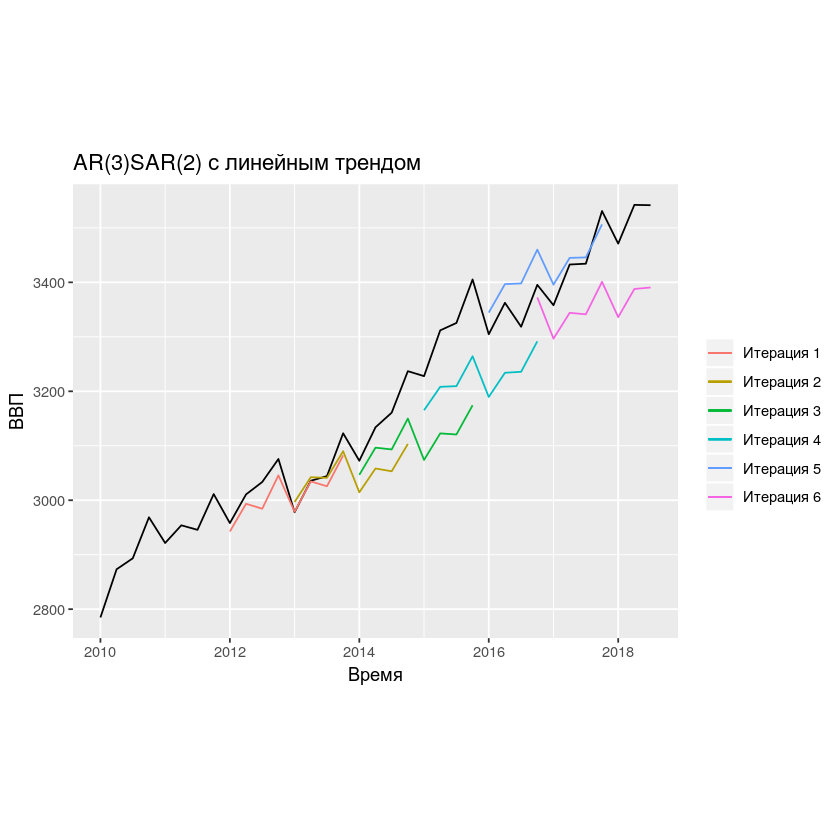

In [14]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [15]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
62.237567 84.911369  2.257129 10.833333

In [16]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [17]:
df_mean_acc[2,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,322.2364,13571.27
2 level (state),69.73105,322.2966,13590.31
2 level (type),68.82769,322.3154,12888.11
2 level (clusetered),70.06872,318.5989,13401.44


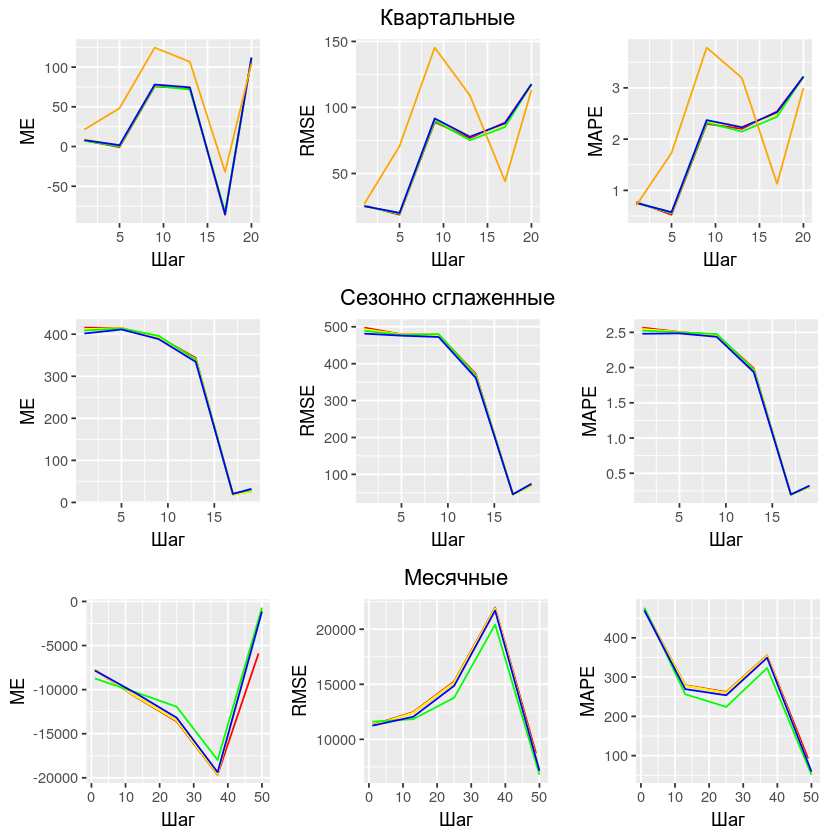

In [18]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [19]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_state.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [20]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

# var_arpdq   <-  c(3,0,0)
# var_sarpdq   <-  c(2,0,0)
# var_char  <-  c(2,1)

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(y)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[2]]  <-  this_model_list



[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
44.59786,46.42144,1.465974,1
49.33443,74.90161,1.857866,5
124.13193,144.00986,3.772963,9
112.99160,115.59723,3.382968,13
-45.04079,52.46222,1.341129,17
99.16860,106.04233,2.846373,20


In [27]:
l[[5]][,1]

Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3345.168 3403.806 3410.204 3473.530 3405.265 3460.855 3467.444 3530.652

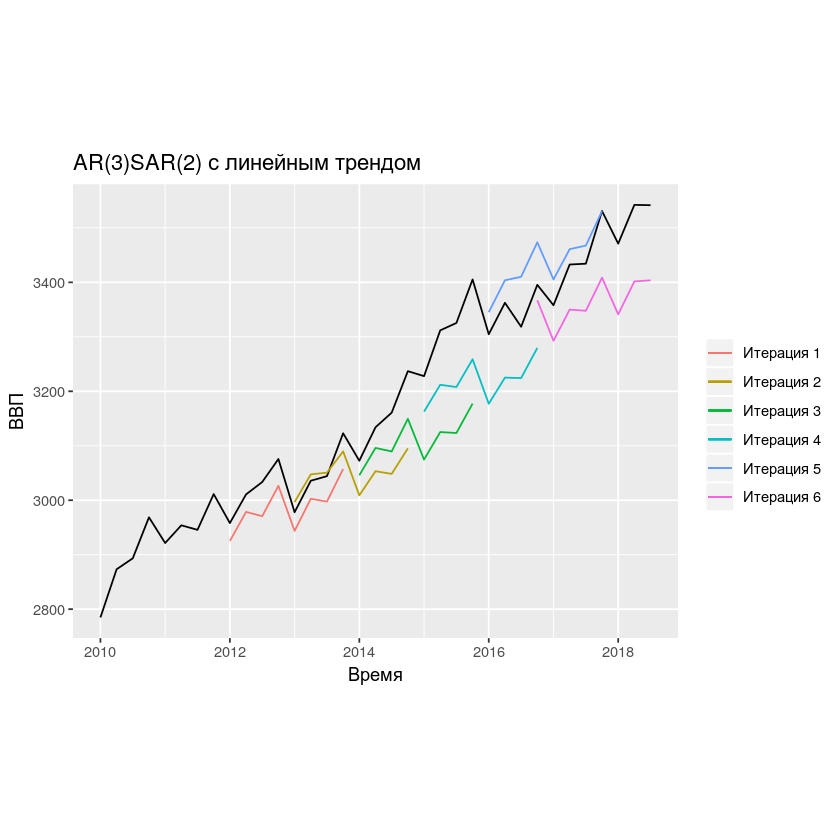

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
64.197270 89.905783  2.444546 10.833333

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,322.2364,13571.27
2 level (state),89.90578,322.2966,13590.31
2 level (type),68.82769,322.3154,12888.11
2 level (clusetered),70.06872,318.5989,13401.44


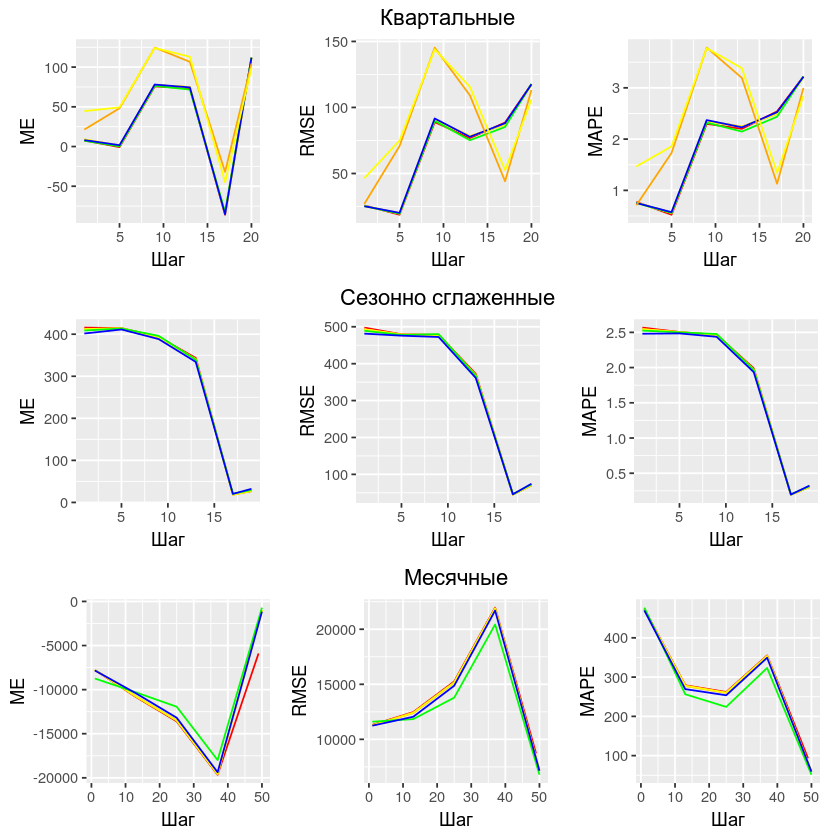

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [34]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [35]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

# var_arpdq   <-  c(3,0,0)
# var_sarpdq   <-  c(2,0,0)
# var_char  <-  c(2,1)

In [36]:
75-69

[1] 6

In [37]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [38]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[3]]  <-  this_model_list



[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


In [39]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [40]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [41]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [42]:
df_acc

ME,RMSE,MAPE,Iteration
3.499421,22.66528,0.7075360,1
10.649920,33.86333,0.9168043,5
84.271215,100.24368,2.5583546,9
53.674344,62.01872,1.6397874,13
-46.937373,55.24095,1.4638227,17
113.794091,121.63718,3.2669351,20


In [43]:
l[[5]][,1]

Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3360.446 3413.465 3410.636 3469.468 3412.957 3461.136 3462.253 3521.737

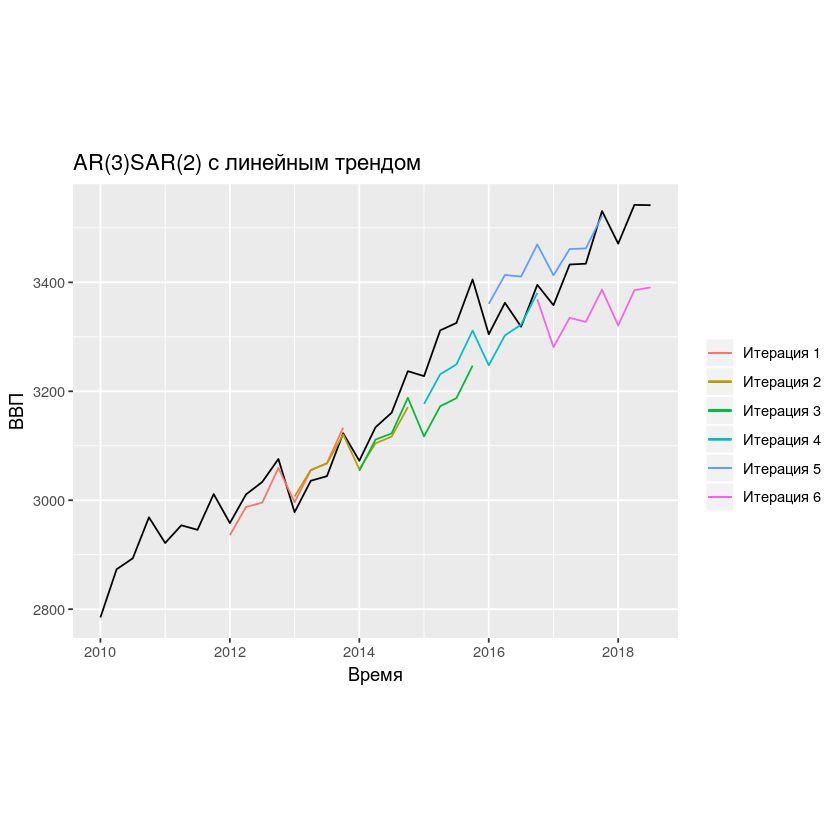

In [44]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [45]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
36.491936 65.944855  1.758873 10.833333

In [46]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [47]:
df_mean_acc[4,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,322.2364,13571.27
2 level (state),89.90578,322.2966,13590.31
2 level (type),65.94486,322.3154,12888.11
2 level (clusetered),70.06872,318.5989,13401.44


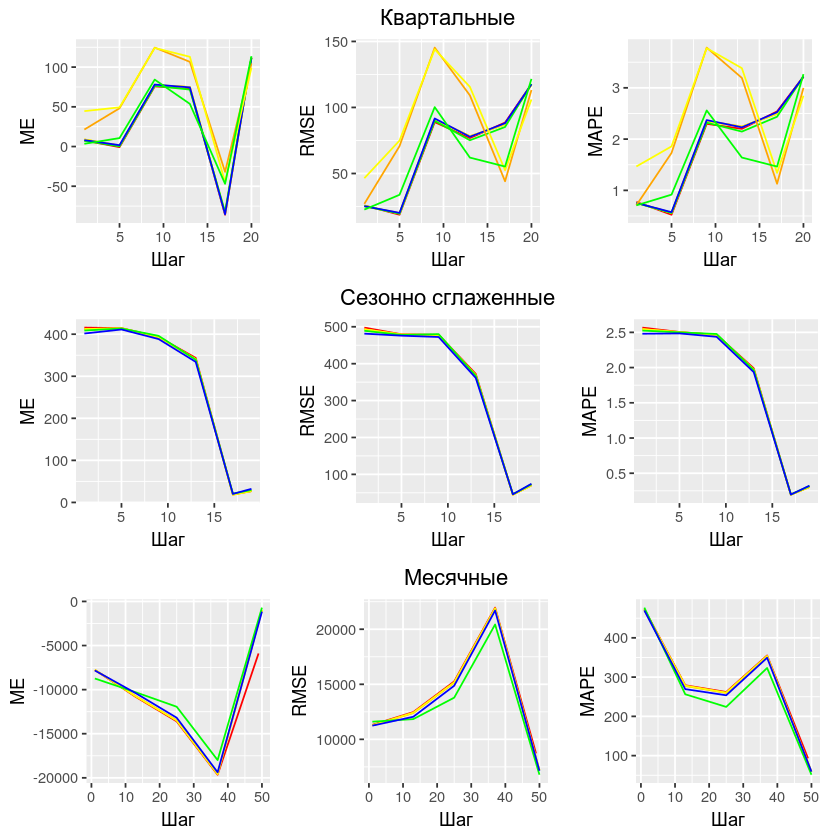

In [48]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [49]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [50]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [51]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0



In [52]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [53]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    
    ms  <-  list()
    
    for(j in 1:ncol(allts)){
       
        ms[[j]]   <- auto.arima(msts(allts[,j], seasonal.periods = var_freq), 
    stationary = FALSE, seasonal = TRUE, lambda=NULL)
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }
this_file_models_list[[4]]  <-  this_model_list



[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Warning message in auto.arima(msts(allts[, j], seasonal.periods = var_freq), stationary = FALSE, :
“Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.”Since argument characters are not specified, the default labelling system is used.


[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


In [54]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [55]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [56]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [57]:
df_acc

ME,RMSE,MAPE,Iteration
20.80750,25.80921,0.6870185,1
64.19772,91.44095,2.2211504,5
138.67751,161.62609,4.2129446,9
98.73476,102.07075,2.9539265,13
-72.27446,76.14621,2.1406463,17
108.41150,117.16566,3.1093777,20


In [58]:
l[[5]][,1]

Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3365.535 3426.089 3429.478 3494.709 3443.513 3493.615 3501.475 3560.381

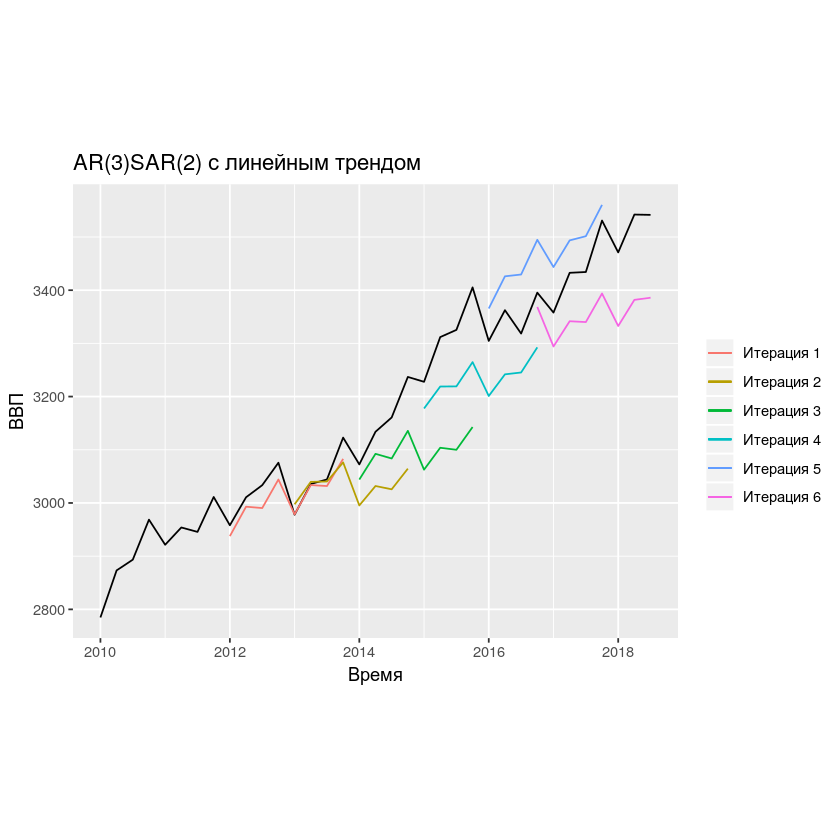

In [59]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [60]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
59.759086 95.709810  2.554177 10.833333

In [61]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [62]:
df_mean_acc[5,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,322.2364,13571.27
2 level (state),89.90578,322.2966,13590.31
2 level (type),65.94486,322.3154,12888.11
2 level (clusetered),95.70981,318.5989,13401.44


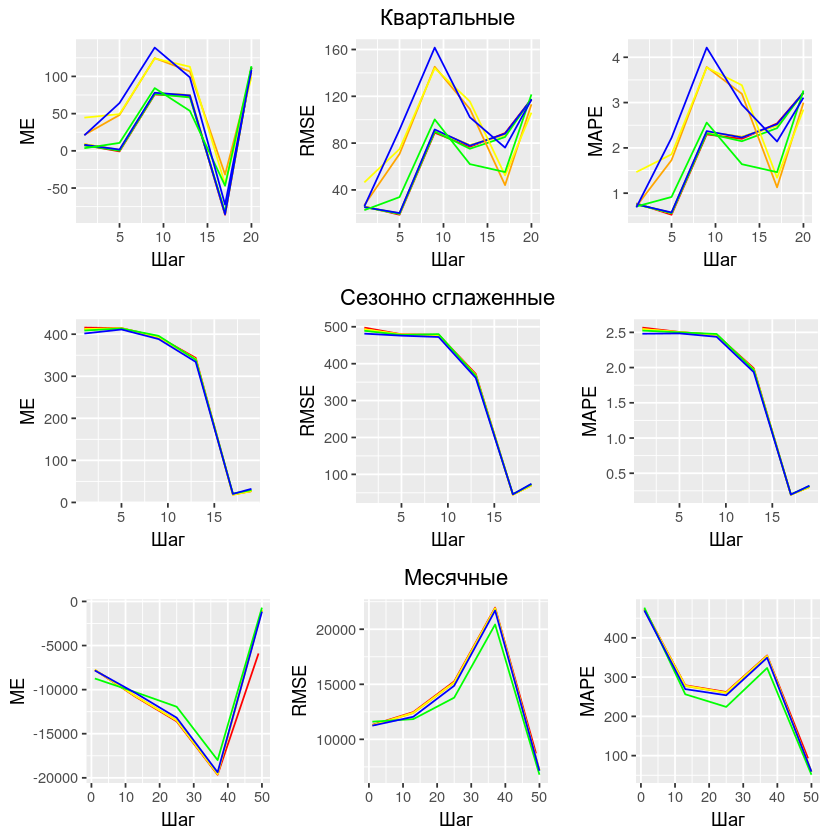

In [63]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [64]:
saveRDS(df_mean_acc, "df_mean_acc_noweights.rds")
saveRDS(plots_test_all, "plots_test_not_all_noweights.rds")



In [65]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,69.40237,323.9779,13948.14
3 level,84.91137,322.2364,13571.27
2 level (state),89.90578,322.2966,13590.31
2 level (type),65.94486,322.3154,12888.11
2 level (clusetered),95.70981,318.5989,13401.44


In [66]:
all_models_list[[1]]  <-  this_file_models_list
saveRDS(all_models_list, "all_models_list.rds")

